# Choosing $\lambda$ and $\sigma$ for Super-resolution

This notebook does a quick test to evaluate super-resolution performance when multiple values of the ridge regularization parameter, $\lambda$, are used in the scene-level regression, and when multiple length scales, $\sigma$, are used for a gaussian filter applied as a post-prediction smoothing step. Because super-resolution is a different task than scene-level prediction, the optimal $\lambda$ differs from that seen in the regressions for Fig 2.

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import gc
from pathlib import Path

import dask.distributed as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from mosaiks import config as c
from mosaiks import transforms
from mosaiks.solve import data_parser as parse
from mosaiks.solve import solve_functions as msolve
from mosaiks.solve import superres as sr
from mosaiks.utils import io
from scipy.ndimage import gaussian_filter

%matplotlib inline

In [2]:
VAL_SET_SIZE = c.superres["val_set_size"]
TEST_LABEL = c.superres["test_label"]
LAMBDAS_TO_TEST = c.superres["lambdas_to_test"]
SIGMAS_TO_TEST = c.superres["sigmas_to_test"]
FACTORS_R2 = c.superres["factors_to_test"]

In [3]:
# derived paths
TRUE_HMAPS_FPATH = (
    Path(c.data_dir) / "int" / "applications" / TEST_LABEL / "sr_true.npz"
)

save_data_dir = Path(c.data_dir) / "int" / f"superres_hp_eval_n_{VAL_SET_SIZE}"

# make sure save_data_dir exists; if not, make it
save_data_dir.mkdir(exist_ok=True, parents=True)

# save paths
preds_fpath = save_data_dir / "preds.npz"

# load config for this label
c = io.get_filepaths(c, TEST_LABEL)
c_app = getattr(c, TEST_LABEL)

## Run scene-level regressions with differing hyperparameters

In [4]:
# load X
X, latlons, net_pred = io.load_superres_X(c)

# load Y
Y = io.get_Y(c, TEST_LABEL)

# shuffle
Y = Y.sample(frac=1, random_state=0)

# merge x and y
Y, X, latlons, ids = parse.merge(Y, X, latlons, pd.Series(Y.index, index=Y.index))
X, Y, latlons = transforms.dropna_and_transform(X, Y, latlons, c_app)

# send to GPU if available
X = msolve.xp.asarray(X)
Y = msolve.xp.asarray(Y)

# get weights for diff lambdas
XtX = X.T.dot(X)
XtY = X.T.dot(Y)
weights = []
for lam in LAMBDAS_TO_TEST:
    weights.append(
        msolve.linalg.solve(
            XtX + lam * msolve.xp.eye(XtX.shape[0], dtype=np.float64),
            XtY,
            **msolve.linalg_solve_kwargs,
        )
    )
weights = msolve.asnumpy(np.stack(weights, axis=-1))

In [5]:
# if running on GPU, this is necessary to clear cache before sr preds
%xdel X
%xdel Y
%xdel XtX
%xdel XtY

gc.collect()
if msolve.GPU:
    msolve.mempool.free_all_blocks()

## Make super-resolution predictions

In [ ]:
# these are ids that will be used for prediction so we need to
# exclude from validation
Y_pred = io.get_multiple_Y(c, labels=["population", "treecover"], allow_logs=False)
Y_pred = Y_pred.sample(frac=1, random_state=0)
pred_ids = Y_pred.index[-c.superres["n_pred_images"] :]
valid = np.isin(ids, pred_ids)

# remove the ids used in prediction
ids = ids[valid]
latlons = latlons[valid]

ids = ids[:VAL_SET_SIZE]
pred_maps = sr.make_superres_predictions(latlons[:VAL_SET_SIZE], weights, net_pred)

going through test frames
completed 0 of 1000
completed 50 of 1000


In [ ]:
# save weights and preds as intermediate step
np.savez_compressed(
    preds_fpath, weights=weights, lambdas=LAMBDAS_TO_TEST, preds=pred_maps, ids=ids
)

## Gaussian filtering of predictions

In [ ]:
# load if running from intermediate step
data = np.load(preds_fpath, allow_pickle=True)
pred_maps = data["preds"]
lambdas = data["lambdas"]
ids = data["ids"]
weights = data["weights"]

In [ ]:
# check different filter widths
sigmas = [8, 16, 32]

# filter images
print("computing filters")

# use dask for parallelism
client = dd.Client()


def filter_all_lambdas(img, sigma):
    return np.stack(
        [gaussian_filter(img[..., i], sigma=sigma) for i in range(img.shape[-1])]
    )


hmaps_pred_filtered = []
for sigma in sigmas:
    ftrs = client.map(lambda x: filter_all_lambdas(x, sigma), pred_maps)
    # must swap axes from img_id, sigma, i, j to sigma, img_id, i, j
    hmaps_pred_filtered.append(np.swapaxes(np.stack(client.gather(ftrs)), 0, 1))
hmaps_pred_filtered = np.stack(hmaps_pred_filtered)

## Evaluate performance of diff lambdas

### Load truth and clean

In [22]:
# get true pixel-level values
data_true = np.load(TRUE_HMAPS_FPATH)
all_hmaps = data_true["frames"]

# convert to DataArray to facilitate reindexing on id
all_hmaps = xr.DataArray(
    all_hmaps,
    coords={
        "image_id": data_true["ids"],
        "i": range(all_hmaps.shape[1]),
        "j": range(all_hmaps.shape[2]),
    },
    dims=["image_id", "i", "j"],
)
hmaps_true = all_hmaps.sel(image_id=ids).values

# make sure to account for nans in int
hmaps_true = np.where(hmaps_true != 255, hmaps_true, np.nan)

# crop truth it has the same window as preds, which is divisible by 32
this_hmaps_true, this_hmaps_pred = sr.crop_rasters_for_sr(
    FACTORS_R2[-1], hmaps_true, hmaps_pred_filtered
)

# drop images with null ground truth pixels b/c messes with means
valid_images = ~np.isnan(this_hmaps_true).any(axis=(1, 2))
this_hmaps_true = this_hmaps_true[valid_images]
this_hmaps_pred = this_hmaps_pred[:, :, valid_images, :, :]

### Calculate R2

In [26]:
# choose SR pixel widths
widths_r2 = [int(this_hmaps_true.shape[1] / x) for x in FACTORS_R2]

# get clipping bounds (we do not use logs in superres)
bounds = c_app["us_bounds_pred"]

# get r2
r2s_s_l = np.ones((len(sigmas), len(lambdas), len(FACTORS_R2))) * np.nan
for sx, sigma in enumerate(sigmas):
    print(f"sigma = {sigma}")
    for lx, l in enumerate(lambdas):
        print(f"lambda = {l}")
        r2s_s_l[sx, lx] = sr.across_image_r2s(
            this_hmaps_pred[sx, lx].squeeze(),
            this_hmaps_true,
            widths_r2,
            demean=True,
            clip=True,
            bounds=bounds,
        )

sigma = 8
lambda = 10000.0
112
56
28
14
7
lambda = 100000.0
112
56
28
14
7
lambda = 1000000.0
112
56
28
14
7
lambda = 10000000.0
112
56
28
14
7
sigma = 16
lambda = 10000.0
112
56
28
14
7
lambda = 100000.0
112
56
28
14
7
lambda = 1000000.0
112
56
28
14
7
lambda = 10000000.0
112
56
28
14
7
sigma = 32
lambda = 10000.0
112
56
28
14
7
lambda = 100000.0
112
56
28
14
7
lambda = 1000000.0
112
56
28
14
7
lambda = 10000000.0
112
56
28
14
7


## Plot

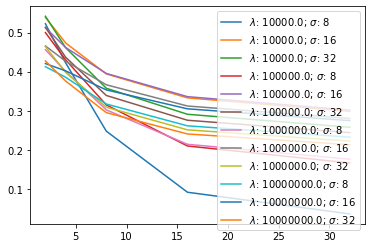

In [27]:
for lx, l in enumerate(lambdas):
    for sx, s in enumerate(sigmas):
        plt.plot(
            FACTORS_R2,
            r2s_s_l[sx, lx],
            label=f"$\lambda$: {l}; $\sigma$: {s}",
        )
plt.legend()

# Save best $\lambda$ and $\sigma$

In [30]:
best_ixs = np.argwhere(r2s_s_l[..., -1] == r2s_s_l[..., -1].max()).squeeze()

assert best_ixs.ndim == 1
best_sigma = SIGMAS_TO_TEST[best_ixs[0]]
best_lambda = LAMBDAS_TO_TEST[best_ixs[0]]

In [32]:
np.savez_compressed(
    preds_fpath,
    weights=weights,
    lambdas=LAMBDAS_TO_TEST,
    preds=pred_maps,
    ids=ids,
    best_lambda=best_lambda,
    best_sigma=best_sigma,
)